# 감정분류 모델_(언더샘플링 O)

In [1]:
# 필요한 모듈 임포트
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
# 데이터 불러오기

train_file = "c:/2nd_project/Data/talk_data/영화주제 대화 말뭉치 라벨링.csv"
data = pd.read_csv(train_file, delimiter=',')
data = data[data['label'] != 0]
data.head()

,text,label
6,정말요 어떤 내용이래요,3
12,애니메이션이면 개봉하면 저도 꼭 봐야겠어요,1
43,그거 말고 추천작은요,1
99,맞어 나 진짜 많이 봐 신의 탑이랑 일요 웹툰에 23보는데 꼭 봐주라 존잼,1
184,모가디슈 내용이 뭐야,3


In [3]:
# 데이터 분포 확인

data['label'].value_counts()

label
6    1590
1    1415
3    1137
4     239
2     184
Name: count, dtype: int64

In [4]:
# 언더샘플링
train_cols = data.columns[:-1]

X = data[train_cols]
y = data['label']

from imblearn.under_sampling import RandomUnderSampler

X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample,columns=train_cols )
y_samp = pd.DataFrame(data=y_sample,columns=['label'])

data_samp=pd.concat([X_samp,y_samp],axis=1)

data_samp["label"].value_counts()

label
1    184
2    184
3    184
4    184
6    184
Name: count, dtype: int64

In [5]:
# 문장과 라벨 분류

queries = data_samp['text'].tolist()
intents = data_samp['label'].tolist()

In [6]:
# 전처리

from Preprocess2 import Preprocess2
p = Preprocess2(word2index_dic='c:/2nd_project/Data/chatbot_dict_talk.bin',
               userdic = 'c:/2nd_project/Data/user_dic.txt')

In [7]:
# 문장 숫자로 변환

sequences = []
for sentence in queries:
    sentence = str(sentence)
    pos = p.pos(sentence)
    keywords = p.get_keywords(pos, without_tag=True)
    seq = p.get_wordidx_sequence(keywords)
    sequences.append(seq)

In [8]:
sequences

[[35, 136, 94, 3, 54, 96, 21],
 [29, 128, 393, 13, 178, 2, 3, 7],
 [136, 514],
 [50, 237, 4, 4, 119, 352, 136, 3, 54],
 [9, 3878, 39, 205, 2, 20, 4, 6027, 136],
 [41, 2, 22, 37, 60, 2, 19],
 [159, 388, 147, 136],
 [9, 61, 30, 91, 30, 2, 136, 331, 96, 21],
 [74, 136, 54, 7866, 157, 224, 2, 20],
 [71, 32, 90, 136, 94],
 [1470, 136, 94, 308, 2],
 [9, 293, 55, 136, 94, 477, 213, 628],
 [32, 293, 372, 90, 136, 54],
 [1, 353, 13, 60],
 [73, 61, 81, 2, 884, 330, 4, 178, 2],
 [9, 547, 30, 55, 855, 35, 742, 695],
 [39, 9, 2, 87, 13, 4],
 [525, 609, 1329, 77, 213, 11017, 1307, 3496, 6260, 789, 4, 136],
 [785, 771, 4, 136, 160, 2, 132, 192, 192, 904, 1980, 2, 21],
 [32, 136, 116, 20, 21],
 [435, 27, 85, 136, 30, 98, 389],
 [5, 122, 32, 20, 21, 136, 94, 3, 54, 19],
 [228, 2294, 81, 3, 323, 1406, 30, 31, 360, 4, 47, 873],
 [9, 55, 155, 4, 178, 2, 3],
 [105, 392, 141, 61, 136, 87],
 [136, 94, 3, 54, 13, 7],
 [873, 58, 66, 251, 7],
 [84, 13, 122, 60],
 [403, 246, 187, 136, 54],
 [8, 7, 260, 378, 1387

In [9]:
# 제로 패딩

from GlobalParams import MAX_SEQ_LEN

padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

In [10]:
padded_seqs

array([[   35,   136,    94, ...,     0,     0,     0],
       [   29,   128,   393, ...,     0,     0,     0],
       [  136,   514,     0, ...,     0,     0,     0],
       ...,
       [  835,  1373,   317, ...,     0,     0,     0],
       [14766,     0,     0, ...,     0,     0,     0],
       [  513,   317,   345, ...,     0,     0,     0]])

In [11]:
padded_seqs.shape

(920, 15)

In [12]:
# X = corpus_df[['text']].astype(str)
X = padded_seqs
y = data_samp['label']

pd.Series(y).value_counts()

label
1    184
2    184
3    184
4    184
6    184
Name: count, dtype: int64

In [13]:
X.shape

(920, 15)

In [14]:
print(X)
print('='*40)
print(y)

[[   35   136    94 ...     0     0     0]
 [   29   128   393 ...     0     0     0]
 [  136   514     0 ...     0     0     0]
 ...
 [  835  1373   317 ...     0     0     0]
 [14766     0     0 ...     0     0     0]
 [  513   317   345 ...     0     0     0]]
17705    1
66831    1
28060    1
10948    1
13614    1
        ..
73958    6
73102    6
73690    6
73415    6
73027    6
Name: label, Length: 920, dtype: int64


In [15]:
encoder = LabelEncoder()
y_label = encoder.fit_transform(y)
y_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [16]:
print(len(y_label))
np.unique(y_label)

920


array([0, 1, 2, 3, 4], dtype=int64)

In [17]:
# train 데이터와 test 데이터 나누기(8:2)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_label, stratify=y, test_size=0.2, random_state=0)

In [18]:
np.unique(y_train)

array([0, 1, 2, 3, 4], dtype=int64)

In [19]:
pd.Series(y_train).value_counts()

2    148
3    147
0    147
1    147
4    147
Name: count, dtype: int64

In [20]:
# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 5
VOCAB_SIZE = len(p.word_index) + 1 # 전체 단어수 (패딩 0 포함)

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(20)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(20)

In [22]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 15), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
# CNN 모델 정의
input_layer = Input(shape=(MAX_SEQ_LEN,))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)
dropout_emb = Dropout(rate = dropout_prob)(embedding_layer)

conv1 = Conv1D(
    filters=128,
    kernel_size=3,
    padding='same',
    activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)

conv2 = Conv1D(
    filters=128,
    kernel_size=4,
    padding='same',
    activation=tf.nn.relu)(dropout_emb)

pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(
    filters=128,
    kernel_size=5,
    padding='same',
    activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

# 3,4,5gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])

hidden1 = Dense(128, activation=tf.nn.relu)(concat)
hidden2 = Dense(128, activation=tf.nn.relu)(hidden1)
hidden3 = Dense(128, activation=tf.nn.relu)(hidden2)

dropout_hidden = Dropout(rate=dropout_prob)(hidden3)
logits = Dense(5, name='logits')(dropout_hidden)
predictions = Dense(5, activation=tf.nn.softmax)(logits)

# 모델 생성
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 128)      1923968     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 15, 128)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 15, 128)      49280       ['dropout[0][0]']                
                                                                                              

In [24]:
# 콜백 설정

# from keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint('c:/2nd_project/Model/intent_uso_model_0809_a_ep_best.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [25]:
# 모델 학습
hist = model.fit(train_ds, validation_data=test_ds, epochs=EPOCH, verbose=1)
# hist = model.fit(train_ds, validation_data=test_ds, epochs=EPOCH, callbacks=[checkpoint], verbose=1)

model.save('c:/2nd_project/Model/intent_uso_model_0809_a_ep_best(5).h5')

Epoch 1/5
37/37 [==============================] - 4s 25ms/step - loss: 1.4680 - accuracy: 0.3641 - val_loss: 1.1233 - val_accuracy: 0.5543
Epoch 2/5
37/37 [==============================] - 0s 10ms/step - loss: 0.9997 - accuracy: 0.5380 - val_loss: 0.7194 - val_accuracy: 0.6848
Epoch 3/5
37/37 [==============================] - 0s 11ms/step - loss: 0.5795 - accuracy: 0.7473 - val_loss: 0.3286 - val_accuracy: 0.9076
Epoch 4/5
37/37 [==============================] - 0s 11ms/step - loss: 0.1798 - accuracy: 0.9497 - val_loss: 0.0754 - val_accuracy: 0.9728
Epoch 5/5
37/37 [==============================] - 0s 10ms/step - loss: 0.0361 - accuracy: 0.9918 - val_loss: 0.0954 - val_accuracy: 0.9674


### 평가

##### 1) Accuracy / Loss

In [26]:
score = model.evaluate(X_test,y_test,verbose=1)
print('Accuracy : ', score[1])
print('loss : ', score[0])

6/6 [==============================] - 0s 12ms/step - loss: 0.0954 - accuracy: 0.9674
Accuracy :  0.967391312122345
loss :  0.09542065858840942


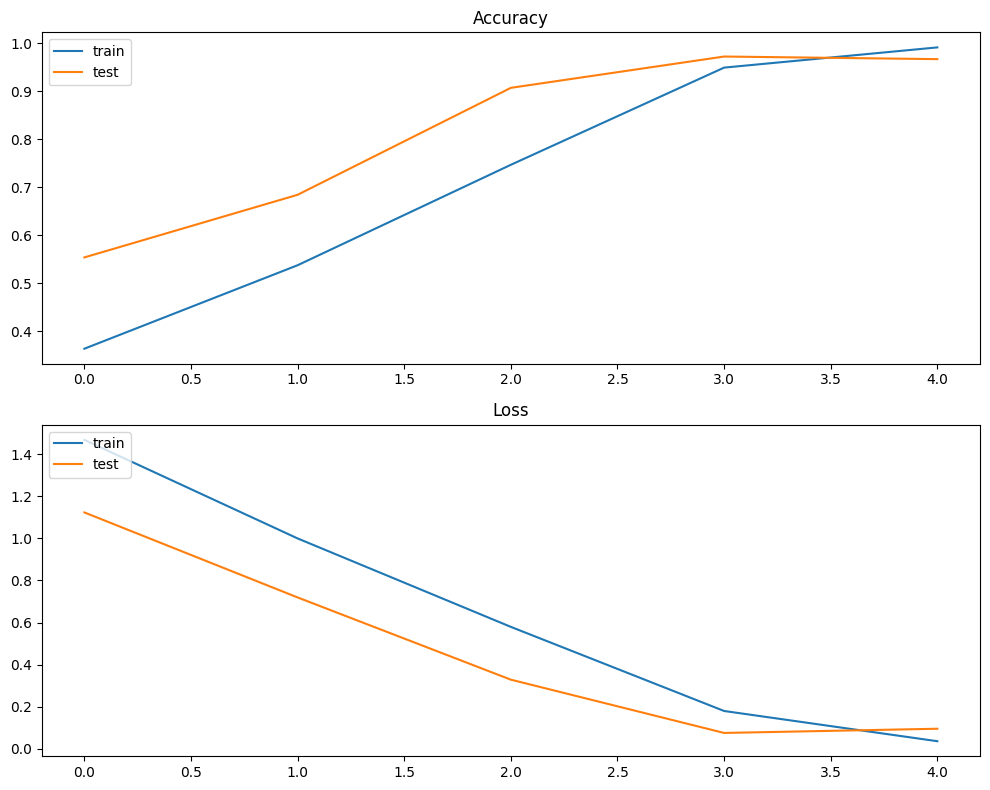

In [27]:
import matplotlib.pyplot as plt


# 그래프 크기 조정
plt.figure(figsize=(10, 8))

# Accuracy 그래프
plt.subplot(2, 1, 1)  # 2행 1열의 첫 번째 subplot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

# Loss 그래프
plt.subplot(2, 1, 2)  # 2행 1열의 두 번째 subplot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')

# 그래프 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

### TEST

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import preprocessing

# 의도 분류 모델 모듈
class StoryModel:
    def __init__(self, model_name, proprocess):
        # intent 레이블
        # self.labels = dict(zip(range(0,12),encoder.classes_.tolist()))
        self.labels = {0: '추천',
                        1: '후기',
                        2: '정보',
                        3: '예매',
                        4: '욕설',
                        }
        # intent 분류 모델 불러오기
        self.model = load_model(model_name)
        # 챗봇 Preprocess 객체
        self.p = proprocess

    # 의도 클래스 예측
    def predict_class(self, query):
        # 형태소 분석
        pos = self.p.pos(query)

        # 문장내 키워드 추출(불용어 제거)
        keywords = self.p.get_keywords(pos, without_tag=True)
        sequences = [self.p.get_wordidx_sequence(keywords)]

        # 패딩처리
        padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')
        predict = self.model.predict(padded_seqs)
        predict_class = tf.math.argmax(predict, axis=1)

        return predict_class.numpy()[0]

In [29]:
from Preprocess2 import Preprocess2
p = Preprocess2(word2index_dic='c:/2nd_project/Data/chatbot_dict_talk.bin',
               userdic = 'c:/2nd_project/Data/user_dic.txt')

intent = StoryModel(model_name='c:/2nd_project/Model/intent_uso_model_0809_a_ep_best(5).h5', proprocess=p)

items=["오늘 영화 예약 해줘", "씨발", "내일 영화 추천 해봐라", "인터스텔라 내용이 뭐야?", "7번방의 선물 후기 좀"]

for item in items:
    predict = intent.predict_class(item)
    predict_label = intent.labels[predict]

    print(item)
    print("의도 예측 클래스 : ", predict)
    print("의도 예측 레이블 : ", predict_label)

1/1 [==============================] - 0s 348ms/step
오늘 영화 예약 해줘
의도 예측 클래스 :  3
의도 예측 레이블 :  예매
1/1 [==============================] - 0s 21ms/step
씨발
의도 예측 클래스 :  4
의도 예측 레이블 :  욕설
1/1 [==============================] - 0s 22ms/step
내일 영화 추천 해봐라
의도 예측 클래스 :  0
의도 예측 레이블 :  추천
1/1 [==============================] - 0s 21ms/step
인터스텔라 내용이 뭐야?
의도 예측 클래스 :  2
의도 예측 레이블 :  정보
1/1 [==============================] - 0s 21ms/step
7번방의 선물 후기 좀
의도 예측 클래스 :  1
의도 예측 레이블 :  후기
